### Pairs Trading in Energy Stocks

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS

In [3]:
symbol_list = ['XOM', 'PSX', 'VLO', 'CVX', 'DQ', 'FSLR', 'SPY']
prices_df = yf.download(symbol_list, start = '2013-01-01', end = '2014-01-01')['Close']
prices_df

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  7 of 7 completed


Ticker,CVX,DQ,FSLR,PSX,SPY,VLO,XOM
Date,,,,,,,
2013-01-02,64.355682,1.660,31.990000,35.305634,116.609306,20.300966,52.390255
2013-01-03,64.081703,1.716,34.410000,33.983120,116.345833,19.866117,52.295769
2013-01-04,64.419815,1.658,33.590000,33.951172,116.856789,20.203697,52.537914
2013-01-07,63.982586,1.610,31.370001,32.813927,116.537460,19.654409,51.929596
2013-01-08,63.696918,1.640,31.020000,32.960876,116.202133,19.837507,52.254429
...,...,...,...,...,...,...,...
2013-12-24,74.373863,6.940,55.290001,48.765015,148.994202,31.068184,60.196796
2013-12-26,75.156677,6.778,55.680000,49.012959,149.751663,31.151226,61.216045
2013-12-27,75.409630,6.838,55.259998,48.771534,149.743546,31.093740,61.586140


In [4]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    p_value_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            p_value = result[1]
            score_matrix[i, j] = score
            p_value_matrix[i, j] = p_value
            if p_value < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, p_value_matrix, pairs

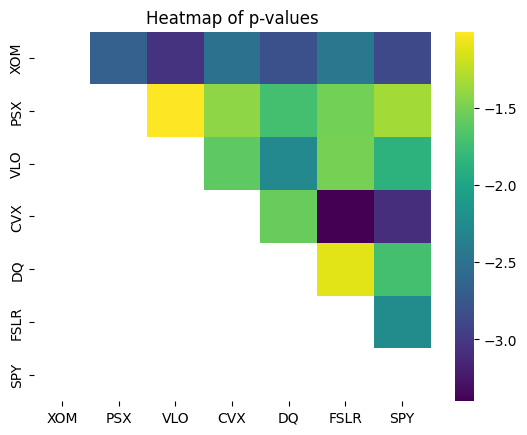

In [5]:
score_matrix, p_value_matrix, pairs = find_cointegrated_pairs(prices_df)
sns.heatmap(score_matrix, xticklabels = symbol_list, yticklabels = symbol_list, cmap = 'viridis', mask = (p_value_matrix >= 0.95))
plt.title("Heatmap of p-values")
plt.show()

In [6]:
print(pairs)

[('PSX', 'VLO')]


In [8]:
S1 = prices_df['PSX']
S2 = prices_df['VLO']
score, p_value, _ = coint(S1, S2)
print("Score: ", score)
print("p-value: ", p_value)

Score:  -3.4003008725569543
p-value:  0.04231706332099965


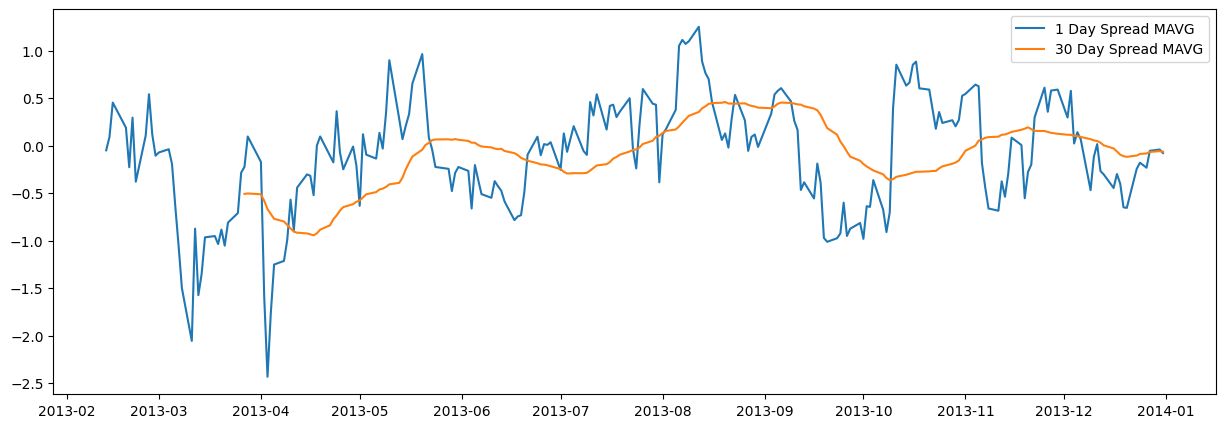

In [10]:
X = sm.add_constant(S1)
result = RollingOLS(S2, X, window = 30).fit()
alpha = result.params['const']
beta = result.params['PSX']
spread = S2 - (alpha + (beta * S1))
spread_mavg1 = spread.rolling(window = 1).mean()
spread_mavg30 = spread.rolling(window = 30).mean()
plt.figure(figsize = (15, 5))
plt.plot(spread_mavg1, label = '1 Day Spread MAVG')
plt.plot(spread_mavg30, label = '30 Day Spread MAVG')
plt.legend()
plt.show()

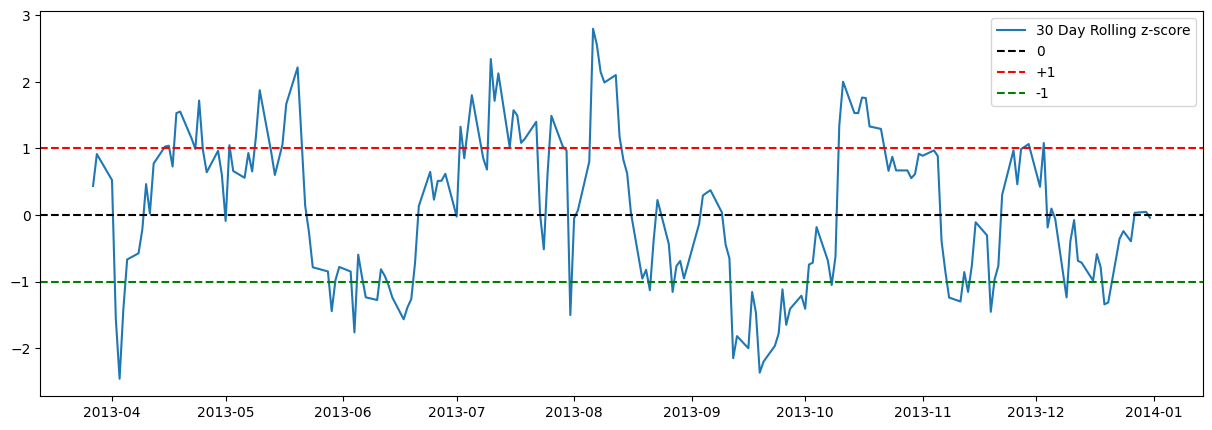

In [12]:
std_30 = spread.rolling(window = 30).std()
zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30
plt.figure(figsize = (15, 5))
plt.plot(zscore_30_1, label = '30 Day Rolling z-score')
plt.axhline(0.0, color = 'black', linestyle = '--', label = "0")
plt.axhline(1.0, color = 'red', linestyle = '--', label = "+1")
plt.axhline(-1.0, color = 'green', linestyle = '--', label = "-1")
plt.legend()
plt.show()

In [14]:
signal = pd.Series(0, index = zscore_30_1.index)
signal[zscore_30_1 > 2] = -1
signal[zscore_30_1 < -2] = 1
signal = signal.shift(1).fillna(0)

In [15]:
S1_returns = S1.pct_change()
S2_returns = S2.pct_change()
spread_returns = S2_returns - (beta * S1_returns)
strategy_returns = spread_returns * signal
cumulative_returns = (1 + strategy_returns).cumprod()

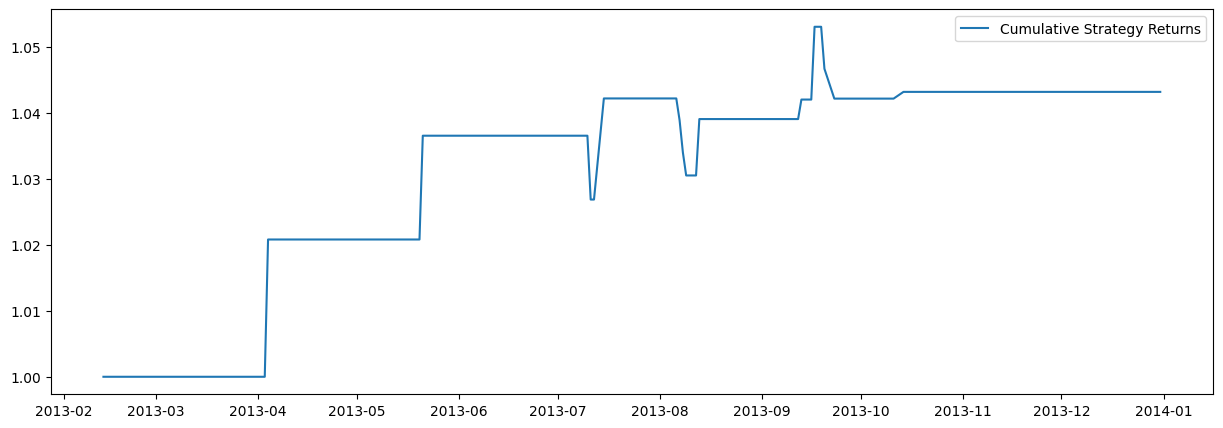

In [16]:
plt.figure(figsize = (15, 5))
plt.plot(cumulative_returns, label = 'Cumulative Strategy Returns')
plt.legend()
plt.show()